<a href="https://colab.research.google.com/github/camdenmcgath/Artificial-Judge/blob/master/supreme_court_judge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install evaluate transformers seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [1]:
import pandas as pd
import re
import evaluate
import numpy as np
import transformers as trans
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
import torch
from torch.optim import AdamW, lr_scheduler
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline
import nltk
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns

import os
import gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2048"


In [2]:
cases = pd.read_csv("justice.csv")
cases.drop(columns=['Unnamed: 0', 'ID', 'name', 'href', 'docket', 'term',  
                    'majority_vote', 'minority_vote', 'decision_type', 'disposition', 'issue_area'], inplace=True)
cases.dropna(inplace=True)


In [3]:
cases = cases.rename(columns={'first_party_winner': 'winning_party_idx'})
for i, row in cases.iterrows():
    if row['winning_party_idx'] == True:
        cases.loc[i, 'winning_party_idx'] = 0
    else:
        cases.loc[i, 'winning_party_idx'] = 1

In [4]:

# Create a mirrored case for each case, where the parties are swapped to prevent favoring first_party
mirrored_cases = cases.copy()
mirrored_cases['first_party'], mirrored_cases['second_party'] = mirrored_cases['second_party'], mirrored_cases['first_party']
mirrored_cases['winning_party_idx'] = (mirrored_cases['winning_party_idx'] == 0).astype(int)
mirrored_cases.reset_index(drop=True, inplace=True)

cases = pd.concat([cases, mirrored_cases])
cases.reset_index(drop=True, inplace=True)
print(f'There are {len(cases)} cases.')
print(f'There are {len(cases[cases["winning_party_idx"]==0])} rows for class 0.')
print(f'There are {len(cases[cases["winning_party_idx"]==1])} rows for class 1.')

There are 6572 cases.
There are 3286 rows for class 0.
There are 3286 rows for class 1.


In [5]:
cases['facts'] = cases['facts'].str.replace(r'<[^<]+?>', '', regex=True)
cases['facts'] = cases['facts'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\'\s]', '', x))
cases['facts'] = cases['facts'].str.lower()
cases['facts'] = cases.apply(lambda x: f"{x['first_party']} [SEP] {x['second_party']} [SEP] {x['facts']}", axis=1)

def word_count(text):
  return len(text.split())

cases['facts_len'] = cases['facts'].apply(word_count)
cases['facts_len'].describe()

count    6572.000000
mean      181.251065
std        84.117624
min         7.000000
25%       126.000000
50%       171.000000
75%       225.000000
max       976.000000
Name: facts_len, dtype: float64

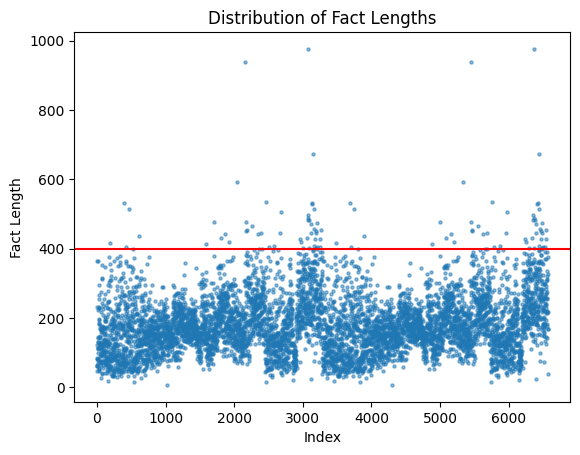


Percentage of cases with fact word no greater than 390: 98.48%


In [6]:
# Create a scatterplot of the fact lengths
plt.scatter(range(len(cases['facts_len'])), cases['facts_len'], s=5, alpha=0.5)

plt.axhline(y=400, color='red')

plt.xlabel('Index')
plt.ylabel('Fact Length')
plt.title('Distribution of Fact Lengths')

plt.show()

# Count the number of facts below 2500 length
num_short_facts = len(cases[cases['facts_len'] <= 400])

# Calculate the percentage of short facts
percentage_short_facts = num_short_facts / len(cases) * 100
print(f"\nPercentage of cases with fact word no greater than 400: {percentage_short_facts:.2f}%")

In [7]:
cases = cases[cases['facts_len'] <= 400]
print(cases['facts_len'].describe())

train_facts, val_facts, train_winners,  val_winners = train_test_split(
    cases['facts'], cases['winning_party_idx'], test_size=0.33, random_state=42)

def describe_facts(txt_df):
  txt_df2 = txt_df.copy()
  txt_df2['word_count'] = txt_df.apply(word_count)
  print(txt_df2['word_count'].describe())

#ensure train/test data has similar text size distribution
describe_facts(train_facts)
describe_facts(val_facts)
print(train_winners.describe())
print(val_winners.describe())

cases = cases.drop(columns=['first_party', 'second_party', 'facts_len'])
train_facts, val_facts = train_facts.tolist(), val_facts.tolist()
train_winners, val_winners = [str(i) for i in train_winners], [str(i) for i in val_winners]

#leave truncate flag off to ensure that no data is truncated
#if data is too large this code will not run
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_facts, padding=True)
val_encodings = tokenizer(val_facts, padding=True)


count    6472.000000
mean      176.641533
std        74.824900
min         7.000000
25%       125.000000
50%       170.000000
75%       222.000000
max       400.000000
Name: facts_len, dtype: float64
count    4336.000000
mean      177.464253
std        74.147352
min         7.000000
25%       126.000000
50%       171.000000
75%       222.000000
max       400.000000
Name: facts, dtype: float64
count    2136.000000
mean      174.971442
std        76.171959
min         7.000000
25%       121.000000
50%       166.000000
75%       221.250000
max       400.000000
Name: facts, dtype: float64
count     4336
unique       2
top          0
freq      2187
Name: winning_party_idx, dtype: int64
count     2136
unique       2
top          1
freq      1087
Name: winning_party_idx, dtype: int64


In [8]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        type(item)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_winners)
val_dataset = TextDataset(val_encodings, val_winners)


In [9]:
#Load pretrained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels=2, 
                                                      hidden_dropout_prob=0.4,
                                                      attention_probs_dropout_prob=0.4)

training_args = TrainingArguments(
    output_dir="test_trainer", 
    logging_dir='logs', 
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    gradient_accumulation_steps=2,
    learning_rate=1e-04,
    logging_steps=50,
)
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Evaluate on the validation set
result = trainer.predict(val_dataset)

# Extract the predicted and true labels from the evaluation results
y_pred = result.predictions.argmax(axis=1)
y_true = result.label_ids

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()